# Data Quality Check — IBOV Top40 Features

Este notebook valida se o dataset gerado em `data/processed/ibov_top40_features.(parquet|csv)` foi carregado corretamente e se está adequado para treinar um modelo direcional (alta/queda) semanal/mensal.

Checklist:

- Arquivo existe e carrega
- Tipos e datas ok
- Sem duplicatas (date, ticker)
- Cobertura por ticker e intervalos de datas
- NaNs controlados em features
- Targets (`target_w`, `target_m`) com distribuição razoável
- Dataset pronto para split temporal


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

PARQUET_PATH = "../data/processed/ibov_top40_features.parquet"
CSV_PATH = "../data/processed/ibov_top40_features.csv"

def load_dataset():
    if os.path.exists(PARQUET_PATH):
        df_ = pd.read_parquet(PARQUET_PATH)
        source_ = PARQUET_PATH
    elif os.path.exists(CSV_PATH):
        df_ = pd.read_csv(CSV_PATH)
        source_ = CSV_PATH
    else:
        raise FileNotFoundError(
            "Não encontrei o arquivo processado. Rode: python -m src.features"
        )
    return df_, source_

df, source = load_dataset()

print("Fonte:", source)
print("Shape:", df.shape)
df.head()


Fonte: ../data/processed/ibov_top40_features.parquet
Shape: (83435, 38)


,date,ticker,open,high,low,close,volume,adjustedClose,adj_close,ret_1d,logret_1d,mom_5d,mom_21d,mom_63d,mom_126d,mom_252d,ma_10,price_to_ma_10,ma_21,price_to_ma_21,ma_63,price_to_ma_63,ma_126,price_to_ma_126,ma_252,price_to_ma_252,vol_10,vol_21,vol_63,logvol,logvol_z_63,hl_range,oc_change,rsi_14,future_ret_w,target_w,future_ret_m,target_m
0,2016-03-23,ABEV3,18.64,19.09,18.60,19.00,19093200,12.72,12.72,0.013546,0.013455,0.038367,0.040065,NaN,NaN,NaN,12.395,0.026220,12.343333,0.030516,NaN,NaN,NaN,NaN,NaN,NaN,0.014986,0.017234,NaN,16.764843,NaN,0.026344,0.019313,55.268818,-0.009434,0,0.007075,1
1,2016-03-23,BBAS3,9.99,9.99,9.75,9.82,19680000,3.03,3.03,-0.038095,-0.038840,0.086022,0.485294,NaN,NaN,NaN,3.146,-0.036872,2.772381,0.092923,NaN,NaN,NaN,NaN,NaN,NaN,0.098511,0.077428,NaN,16.795113,NaN,0.024615,-0.017017,53.392542,0.006601,1,0.059406,1
2,2016-03-23,BBDC3,14.56,14.67,14.10,14.29,3466917,8.63,8.63,-0.031425,-0.031930,0.107831,0.470187,NaN,NaN,NaN,8.496,0.015772,7.472381,0.154920,NaN,NaN,NaN,NaN,NaN,NaN,0.060574,0.045867,NaN,15.058776,NaN,0.040426,-0.018544,70.921669,-0.004635,0,-0.089224,0
3,2016-03-23,BBDC4,12.94,13.01,12.53,12.69,23897005,7.66,7.66,-0.032828,-0.033379,0.086525,0.421150,NaN,NaN,NaN,7.636,0.003143,6.815238,0.123952,NaN,NaN,NaN,NaN,NaN,NaN,0.061783,0.051653,NaN,16.989264,NaN,0.038308,-0.019320,64.715333,0.011749,1,-0.067885,0
4,2016-03-23,BBSE3,29.08,29.52,28.15,28.86,4138100,13.29,13.29,-0.009687,-0.009734,0.039093,0.152645,NaN,NaN,NaN,13.805,-0.037305,12.903333,0.029966,NaN,NaN,NaN,NaN,NaN,NaN,0.058347,0.046827,NaN,15.235747,NaN,0.048668,-0.007565,37.466094,0.029345,1,0.082769,1


In [3]:
required_cols = {
    "date", "ticker", "open", "high", "low", "close", "volume",
    "adj_close", "ret_1d", "logret_1d",
    "target_w", "target_m"
}

missing = required_cols - set(df.columns)
print("Colunas faltando:", missing)

if not np.issubdtype(df["date"].dtype, np.datetime64):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("\nResumo date:")
print("min:", df["date"].min())
print("max:", df["date"].max())
print("datas nulas:", df["date"].isna().sum())

print("\nTipos:")
df.dtypes.head(30)


Colunas faltando: set()

Resumo date:
min: 2016-03-23 00:00:00
max: 2026-02-19 21:07:48
datas nulas: 0

Tipos:


date               datetime64[us]
ticker                        str
open                      float64
high                      float64
low                       float64
close                     float64
volume                      int64
adjustedClose             float64
adj_close                 float64
ret_1d                    float64
logret_1d                 float64
mom_5d                    float64
mom_21d                   float64
mom_63d                   float64
mom_126d                  float64
mom_252d                  float64
ma_10                     float64
price_to_ma_10            float64
ma_21                     float64
price_to_ma_21            float64
ma_63                     float64
price_to_ma_63            float64
ma_126                    float64
price_to_ma_126           float64
ma_252                    float64
price_to_ma_252           float64
vol_10                    float64
vol_21                    float64
vol_63                    float64
logvol        

In [4]:
dups = df.duplicated(subset=["date", "ticker"]).sum()
print("Duplicatas (date, ticker):", dups)

if dups > 0:
    df[df.duplicated(subset=["date", "ticker"], keep=False)].sort_values(["ticker", "date"]).head(20)


Duplicatas (date, ticker): 0


Tickers únicos: 37


,n_rows,start,end
ticker,,,
ALOS3,545,2023-11-27,2026-01-30
VBBR3,1046,2021-11-24,2026-01-30
RDOR3,1259,2021-01-14,2026-01-30
TIMS3,1300,2020-11-12,2026-01-30
B3SA3,1932,2018-04-25,2026-01-30
SUZB3,2020,2017-12-13,2026-01-30
BPAC11,2180,2017-03-28,2026-01-30
RAIL3,2187,2017-04-11,2026-01-30
ITUB4,2352,2016-08-11,2026-01-30


,n_rows,start,end
ticker,,,
LREN3,2450,2016-03-23 00:00:00,2026-01-30 00:00:00
TOTS3,2450,2016-03-23 00:00:00,2026-01-30 00:00:00
VALE3,2450,2016-03-23 00:00:00,2026-01-30 00:00:00
UGPA3,2450,2016-03-23 00:00:00,2026-01-30 00:00:00
ABEV3,2450,2016-03-23 00:00:00,2026-01-30 00:00:00
WEGE3,2450,2016-03-23 00:00:00,2026-01-30 00:00:00
VIVT3,2450,2016-03-23 00:00:00,2026-01-30 00:00:00
AXIA3,2470,2016-03-23 13:00:00,2026-02-19 21:07:48
AXIA6,2470,2016-03-23 13:00:00,2026-02-19 21:07:42


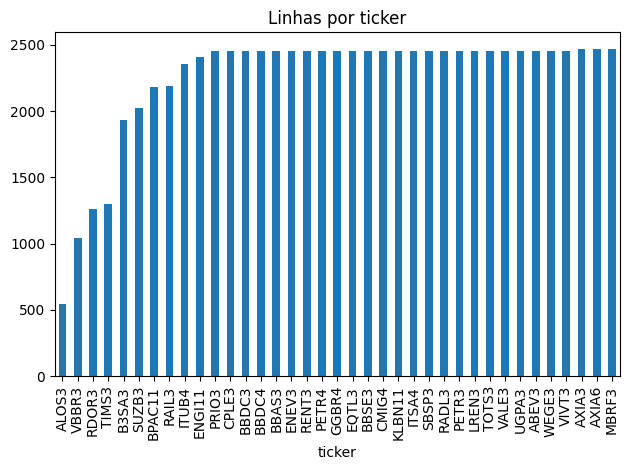

In [5]:
tickers = df["ticker"].nunique()
print("Tickers únicos:", tickers)

per_ticker = df.groupby("ticker").agg(
    n_rows=("date", "size"),
    start=("date", "min"),
    end=("date", "max")
).sort_values("n_rows")

display(per_ticker.head(10))
display(per_ticker.tail(10))

plt.figure()
per_ticker["n_rows"].plot(kind="bar")
plt.title("Linhas por ticker")
plt.tight_layout()
plt.show()


In [6]:
nan_ratio = (df.isna().mean() * 100).sort_values(ascending=False)
nan_ratio.head(30)


mom_252d           10.126446
price_to_ma_252    10.082100
ma_252             10.082100
mom_126d            4.538863
price_to_ma_126     4.494517
ma_126              4.494517
logvol_z_63         2.765027
vol_63              1.862528
mom_63d             1.812189
ma_63               1.769042
price_to_ma_63      1.769042
future_ret_m        0.931264
future_ret_w        0.221729
logvol              0.038353
close               0.000000
low                 0.000000
high                0.000000
open                0.000000
ticker              0.000000
date                0.000000
adj_close           0.000000
volume              0.000000
ma_21               0.000000
price_to_ma_21      0.000000
ma_10               0.000000
price_to_ma_10      0.000000
ret_1d              0.000000
logret_1d           0.000000
mom_5d              0.000000
mom_21d             0.000000
dtype: float64

== target_w ==
n válido: 83435
pct 1: 51.98058368790076
pct 0: 48.01941631209924
classe majoritária: 1
baseline acc: 0.5198058368790076

== target_m ==
n válido: 83435
pct 1: 55.33169533169533
pct 0: 44.66830466830467
classe majoritária: 1
baseline acc: 0.5533169533169533



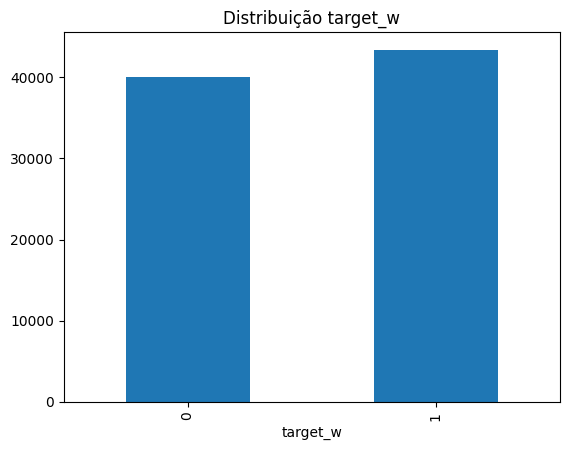

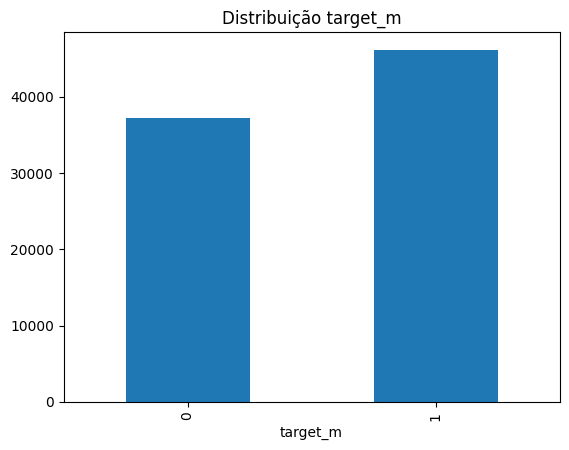

In [8]:
def target_stats(col):
    if col not in df.columns:
        print(f"{col} não existe")
        return
    
    s = df[col].dropna()
    print(f"== {col} ==")
    print("n válido:", len(s))
    print("pct 1:", (s == 1).mean() * 100)
    print("pct 0:", (s == 0).mean() * 100)
    
    maj = int(s.mode().iloc[0])
    baseline_acc = (s == maj).mean()
    print("classe majoritária:", maj)
    print("baseline acc:", baseline_acc)
    print()

target_stats("target_w")
target_stats("target_m")

plt.figure()
df["target_w"].dropna().astype(int).value_counts().sort_index().plot(kind="bar")
plt.title("Distribuição target_w")
plt.show()

plt.figure()
df["target_m"].dropna().astype(int).value_counts().sort_index().plot(kind="bar")
plt.title("Distribuição target_m")
plt.show()


In [9]:
valid_w = df.dropna(subset=["target_w"])
valid_m = df.dropna(subset=["target_m"])

print("Semanal válido:", len(valid_w))
print("Mensal válido:", len(valid_m))

bad_order = 0
for t, g in df.groupby("ticker"):
    if not g["date"].is_monotonic_increasing:
        bad_order += 1

print("Tickers com datas fora de ordem:", bad_order)

leak_cols = [c for c in df.columns if c.startswith("future_ret_")]
print("Colunas de retorno futuro presentes:", leak_cols)


Semanal válido: 83435
Mensal válido: 83435
Tickers com datas fora de ordem: 0
Colunas de retorno futuro presentes: ['future_ret_w', 'future_ret_m']


## O que considerar adequado para treinar?

Você quer ver:

- Duplicatas = 0
- ~40 tickers
- Poucos NaNs nas features principais
- Targets não extremamente desbalanceados (ideal 40/60 ou 45/55)
- Baseline accuracy não muito alto

Se tudo estiver consistente, podemos ir para:

➡️ Split temporal  
➡️ Modelo baseline (Logistic Regression)  
➡️ Métricas (AUC, F1)  
➡️ Backtest simples
